In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('dataset-0510/train.csv')

In [71]:
df.head()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469803,6.476038e+05
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.073573,3.321452e+06
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.462081,9.570885e+06
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.628966,1.421501e+07
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.131236,7.627120e+05


## Check for missing data

In [4]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)

In [5]:
missing_data = pd.concat([total, percent], keys=['Total', 'Percent'], axis = 1)

總共有 4 個 column 有 missing data
- parking_area 和 parking_price 缺太多資料補不了只好刪了
- 看一下 txn_floor 和 village_income_median 能不能捕

In [6]:
missing_data.head()

,Total,Percent
parking_area,56897,0.948283
parking_price,46065,0.767750
txn_floor,15902,0.265033
village_income_median,1142,0.019033
total_price,0,0.000000


In [7]:
df_txn_floor_notnull = df[df['txn_floor'].notnull()]
df_village_income_median_notnull = df[df['village_income_median'].notnull()]

畫出交易樓層跟平均價格的關係
- 看似好像有點關聯

,total_price,txn_floor
total_price,1.000000,0.046155
txn_floor,0.046155,1.000000


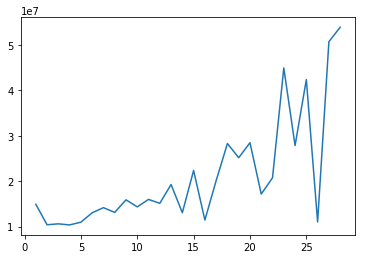

In [8]:
plt.plot(df_txn_floor_notnull.groupby(['txn_floor'])['total_price'].mean())
df_txn_floor_notnull[['total_price','txn_floor']].corr()

但發現大部分的數據其實是集中在 1- 7 樓，而上面的關係圖在 1 - 7 樓並沒有明確的關係，所以果斷捨棄這個 column

In [110]:
df_txn_floor_notnull.groupby(['txn_floor'])['total_price'].count()

txn_floor
1.0     5249
2.0     5498
3.0     6153
4.0     6410
5.0     5107
6.0     2777
7.0     2575
8.0     1771
9.0     1650
10.0    1498
11.0    1398
12.0    1194
13.0     799
14.0     674
15.0     411
16.0     236
17.0     165
18.0     146
19.0     112
20.0      74
21.0      57
22.0      45
23.0      47
24.0      18
25.0      15
26.0       9
27.0       8
28.0       2
Name: total_price, dtype: int64

接下來看一下 village_income_median 能否補值

count    58858.000000
mean       674.840175
std        140.653083
min        411.000000
25%        583.000000
50%        642.000000
75%        729.000000
max       1851.000000
Name: village_income_median, dtype: float64


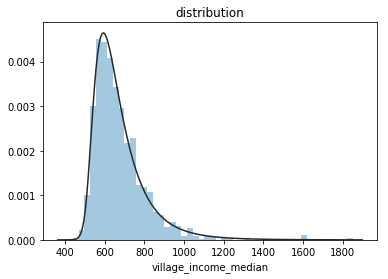

In [9]:
# plt.plot(df_txn_floor_notnull.groupby(['village_income_median'])['total_price'].mean())
print(df_village_income_median_notnull['village_income_median'].describe())
df_village_income_median_notnull[['total_price','village_income_median']].corr()
y = df_village_income_median_notnull['village_income_median']
plt.figure(1); plt.title('distribution')
sns.distplot(y, kde=False, fit=sp.stats.johnsonsu)

看了一下分佈圖直覺告訴我要用眾數來填缺的值

In [10]:
fill_val = df_village_income_median_notnull['village_income_median'].mode()[0]  # 634
df['village_income_median'] = df['village_income_median'].fillna(fill_val)

In [11]:
df.drop(['parking_area','parking_price','txn_floor'],axis=1,inplace=True)

有些 column 裡面只有一種 value，代表大家都有相同的資料

In [12]:
one_value_column = [i for i in df.columns if len(df[i].unique()) < 2]

In [13]:
df.drop(one_value_column,axis=1,inplace=True)

- 到此為止 df 所做的修改就只有把一些沒用的 column 丟掉跟補一些缺值

# 資料處理

- 先把名稱中含有 index 的 column 找出來，他們都是 categorical data
- 再手動把一些 categorical data 標出來
- categorical data: 共 54 個 (不包括 town 跟 village 因為他們種類太多了)
- numerical data: 共 156 個 (全部的 col 減掉 categorical data)

In [15]:
categorical = []

In [16]:
cat = ['total_floor','building_material',
       'city','building_type',
       'building_use','parking_way']

In [17]:
categorical = cat + categorical

In [18]:
numerical = [i for i in df.columns if i not in categorical]

- 把不同種類區分出來之後下一步就是要 get_dummy
- 但為了要一次轉換好必須先把類別資料 type 轉成 str

In [19]:
for col in categorical:
    df[col] = df[col].astype(str)

In [20]:
df_dummy = pd.get_dummies(df[categorical])
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 67 columns):
total_floor_1           60000 non-null uint8
total_floor_10          60000 non-null uint8
total_floor_11          60000 non-null uint8
total_floor_12          60000 non-null uint8
total_floor_13          60000 non-null uint8
total_floor_14          60000 non-null uint8
total_floor_15          60000 non-null uint8
total_floor_16          60000 non-null uint8
total_floor_17          60000 non-null uint8
total_floor_18          60000 non-null uint8
total_floor_19          60000 non-null uint8
total_floor_2           60000 non-null uint8
total_floor_20          60000 non-null uint8
total_floor_21          60000 non-null uint8
total_floor_22          60000 non-null uint8
total_floor_23          60000 non-null uint8
total_floor_24          60000 non-null uint8
total_floor_25          60000 non-null uint8
total_floor_26          60000 non-null uint8
total_floor_27          60000 non-nu

- 接著把轉換好的 dataframe 跟 numerical 的 dataframe 合併

In [21]:
df_after = pd.concat([df[numerical],df_dummy], axis=1) 

- 把剛剛那些步驟寫成 function 為了給之後的 testing data 使用

In [22]:
def dummy_transform(df):
    categorical = []
    cat = ['total_floor','building_material',
       'city','building_type',
       'building_use','parking_way']
    categorical = cat + categorical
    numerical = [i for i in df.columns if i not in categorical]
    for col in categorical:
        df[col] = df[col].astype(str)
    df_dummy = pd.get_dummies(df[categorical])
    return pd.concat([df[numerical],df_dummy], axis=1) 

- load testing data 進來

In [23]:
test = pd.read_csv('dataset-0510/test.csv')

In [24]:
fill_val = test['village_income_median'].mode()[0]  # 634
test['village_income_median'] = test['village_income_median'].fillna(fill_val)

In [25]:
test = test[df.columns[:-1]]
test = dummy_transform(test)

- 發現 training data 裡面有些 column 在 testing data 裡面沒有
    - XI_index_10000_0
    - building_material_5

In [26]:
set(df_after.columns) - set(test.columns)

{'building_material_5', 'total_price'}

In [27]:
test['building_material_5'] = 0

# 產生要訓練 model 的資料

In [122]:
df_after["total_price"].head()

0    6.476038e+05
1    3.321452e+06
2    9.570885e+06
3    1.421501e+07
4    7.627120e+05
Name: total_price, dtype: float64

In [123]:
np.floor(np.expm1(y))[:5]

0      647603.0
1     3321451.0
2     9570885.0
3    14215011.0
4      762711.0
Name: total_price, dtype: float64

In [125]:
model.predict(X_valid)

array([14.541353, 15.175464, 14.898306, ..., 16.310421, 16.534931,
       16.087112], dtype=float32)

In [117]:
y = np.log1p(df_after["total_price"])

In [118]:
X = df_after.drop(['building_id','total_price'],axis=1)

In [119]:
X_valid = X[50000:]
y_valid = y[50000:]
X = X[:50000]
y = y[:50000]

In [120]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 50000 to 59999
Columns: 269 entries, txn_dt to parking_way_2
dtypes: float64(33), int64(169), uint8(67)
memory usage: 16.1 MB


# Training

In [30]:
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor

In [130]:
def validation(prediction, ground_true):
    ground_true = np.floor(np.expm1(ground_true))
    ground_true = ground_true.reset_index(drop=True)
    
    prediction = np.floor(np.expm1(prediction))
    
    score = 0
    for i in range(len(prediction)):
        pred = prediction[i]
        roof = ground_true[i] + ground_true[i] / 10
        floor = ground_true[i] - ground_true[i] / 10
        if (pred <= roof) and (pred >= floor):
            score += 1
    return score

In [141]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=2000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,  # Learning rate
    nthread=8,
    seed=42)

model.fit(
    X, 
    y, 
    eval_metric="rmse", 
    eval_set=[(X, y), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)


[0]	validation_0-rmse:13.5615	validation_1-rmse:13.5562
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:12.2085	validation_1-rmse:12.2045
[2]	validation_0-rmse:10.9908	validation_1-rmse:10.9879
[3]	validation_0-rmse:9.89512	validation_1-rmse:9.89337
[4]	validation_0-rmse:8.90893	validation_1-rmse:8.90868
[5]	validation_0-rmse:8.02134	validation_1-rmse:8.02193
[6]	validation_0-rmse:7.22265	validation_1-rmse:7.22402
[7]	validation_0-rmse:6.50394	validation_1-rmse:6.50605
[8]	validation_0-rmse:5.85729	validation_1-rmse:5.86003
[9]	validation_0-rmse:5.27533	validation_1-rmse:5.27867
[10]	validation_0-rmse:4.75171	validation_1-rmse:4.75518
[11]	validation_0-rmse:4.28065	validation_1-rmse:4.28415
[12]	validation_0-rmse:3.85688	validation_1-rmse:3.86065
[13]	validation_0-rmse:3.47585	validation_1-rmse:3.48001
[14]	validation_0-rmse:3.13294	validation_1-rmse:3.13

[137]	validation_0-rmse:0.235176	validation_1-rmse:0.253361
[138]	validation_0-rmse:0.235019	validation_1-rmse:0.253238
[139]	validation_0-rmse:0.2347	validation_1-rmse:0.25302
[140]	validation_0-rmse:0.234564	validation_1-rmse:0.252928
[141]	validation_0-rmse:0.234357	validation_1-rmse:0.252885
[142]	validation_0-rmse:0.234171	validation_1-rmse:0.252718
[143]	validation_0-rmse:0.23399	validation_1-rmse:0.252629
[144]	validation_0-rmse:0.233836	validation_1-rmse:0.252624
[145]	validation_0-rmse:0.233495	validation_1-rmse:0.252384
[146]	validation_0-rmse:0.233228	validation_1-rmse:0.252162
[147]	validation_0-rmse:0.233167	validation_1-rmse:0.252106
[148]	validation_0-rmse:0.23298	validation_1-rmse:0.251967
[149]	validation_0-rmse:0.232834	validation_1-rmse:0.251872
[150]	validation_0-rmse:0.232554	validation_1-rmse:0.251702
[151]	validation_0-rmse:0.232442	validation_1-rmse:0.251613
[152]	validation_0-rmse:0.232217	validation_1-rmse:0.251459
[153]	validation_0-rmse:0.232119	validation_1

[275]	validation_0-rmse:0.211856	validation_1-rmse:0.241
[276]	validation_0-rmse:0.211743	validation_1-rmse:0.240941
[277]	validation_0-rmse:0.211602	validation_1-rmse:0.240841
[278]	validation_0-rmse:0.211519	validation_1-rmse:0.240791
[279]	validation_0-rmse:0.211314	validation_1-rmse:0.24067
[280]	validation_0-rmse:0.211138	validation_1-rmse:0.240589
[281]	validation_0-rmse:0.211083	validation_1-rmse:0.240555
[282]	validation_0-rmse:0.210852	validation_1-rmse:0.240415
[283]	validation_0-rmse:0.210773	validation_1-rmse:0.240359
[284]	validation_0-rmse:0.210711	validation_1-rmse:0.240313
[285]	validation_0-rmse:0.210668	validation_1-rmse:0.240315
[286]	validation_0-rmse:0.210506	validation_1-rmse:0.240211
[287]	validation_0-rmse:0.210362	validation_1-rmse:0.240211
[288]	validation_0-rmse:0.210141	validation_1-rmse:0.240115
[289]	validation_0-rmse:0.210088	validation_1-rmse:0.240097
[290]	validation_0-rmse:0.209807	validation_1-rmse:0.239941
[291]	validation_0-rmse:0.209646	validation_

[413]	validation_0-rmse:0.197894	validation_1-rmse:0.235794
[414]	validation_0-rmse:0.1978	validation_1-rmse:0.235792
[415]	validation_0-rmse:0.197671	validation_1-rmse:0.235732
[416]	validation_0-rmse:0.197555	validation_1-rmse:0.235674
[417]	validation_0-rmse:0.197429	validation_1-rmse:0.235627
[418]	validation_0-rmse:0.197257	validation_1-rmse:0.235567
[419]	validation_0-rmse:0.197065	validation_1-rmse:0.235509
[420]	validation_0-rmse:0.196934	validation_1-rmse:0.235474
[421]	validation_0-rmse:0.196892	validation_1-rmse:0.235448
[422]	validation_0-rmse:0.196806	validation_1-rmse:0.235469
[423]	validation_0-rmse:0.196654	validation_1-rmse:0.235451
[424]	validation_0-rmse:0.196579	validation_1-rmse:0.235395
[425]	validation_0-rmse:0.196475	validation_1-rmse:0.235382
[426]	validation_0-rmse:0.19631	validation_1-rmse:0.235301
[427]	validation_0-rmse:0.196295	validation_1-rmse:0.235302
[428]	validation_0-rmse:0.196208	validation_1-rmse:0.235264
[429]	validation_0-rmse:0.196061	validation

[551]	validation_0-rmse:0.186325	validation_1-rmse:0.232131
[552]	validation_0-rmse:0.186238	validation_1-rmse:0.232113
[553]	validation_0-rmse:0.186164	validation_1-rmse:0.2321
[554]	validation_0-rmse:0.186101	validation_1-rmse:0.232091
[555]	validation_0-rmse:0.185987	validation_1-rmse:0.232098
[556]	validation_0-rmse:0.185934	validation_1-rmse:0.232085
[557]	validation_0-rmse:0.185865	validation_1-rmse:0.232085
[558]	validation_0-rmse:0.185764	validation_1-rmse:0.232016
[559]	validation_0-rmse:0.185714	validation_1-rmse:0.231992
[560]	validation_0-rmse:0.18564	validation_1-rmse:0.231969
[561]	validation_0-rmse:0.185602	validation_1-rmse:0.231971
[562]	validation_0-rmse:0.185534	validation_1-rmse:0.23197
[563]	validation_0-rmse:0.18551	validation_1-rmse:0.231964
[564]	validation_0-rmse:0.185464	validation_1-rmse:0.231959
[565]	validation_0-rmse:0.185437	validation_1-rmse:0.231981
[566]	validation_0-rmse:0.185422	validation_1-rmse:0.231977
[567]	validation_0-rmse:0.185393	validation_1

[688]	validation_0-rmse:0.176512	validation_1-rmse:0.229825
[689]	validation_0-rmse:0.176446	validation_1-rmse:0.229795
[690]	validation_0-rmse:0.176353	validation_1-rmse:0.229816
[691]	validation_0-rmse:0.176264	validation_1-rmse:0.229802
[692]	validation_0-rmse:0.176089	validation_1-rmse:0.229726
[693]	validation_0-rmse:0.176046	validation_1-rmse:0.229708
[694]	validation_0-rmse:0.175995	validation_1-rmse:0.229715
[695]	validation_0-rmse:0.175901	validation_1-rmse:0.229695
[696]	validation_0-rmse:0.175793	validation_1-rmse:0.229698
[697]	validation_0-rmse:0.175753	validation_1-rmse:0.229698
[698]	validation_0-rmse:0.175595	validation_1-rmse:0.229665
[699]	validation_0-rmse:0.175481	validation_1-rmse:0.229635
[700]	validation_0-rmse:0.175371	validation_1-rmse:0.229604
[701]	validation_0-rmse:0.175339	validation_1-rmse:0.229598
[702]	validation_0-rmse:0.175309	validation_1-rmse:0.229577
[703]	validation_0-rmse:0.175162	validation_1-rmse:0.229506
[704]	validation_0-rmse:0.175121	validat

[826]	validation_0-rmse:0.166476	validation_1-rmse:0.227777
[827]	validation_0-rmse:0.166448	validation_1-rmse:0.22777
[828]	validation_0-rmse:0.166384	validation_1-rmse:0.227729
[829]	validation_0-rmse:0.166339	validation_1-rmse:0.227706
[830]	validation_0-rmse:0.166239	validation_1-rmse:0.227684
[831]	validation_0-rmse:0.166208	validation_1-rmse:0.227659
[832]	validation_0-rmse:0.16608	validation_1-rmse:0.227622
[833]	validation_0-rmse:0.166037	validation_1-rmse:0.227638
[834]	validation_0-rmse:0.16598	validation_1-rmse:0.227645
[835]	validation_0-rmse:0.165902	validation_1-rmse:0.227642
[836]	validation_0-rmse:0.165761	validation_1-rmse:0.227626
[837]	validation_0-rmse:0.1657	validation_1-rmse:0.227612
[838]	validation_0-rmse:0.165685	validation_1-rmse:0.22762
[839]	validation_0-rmse:0.165627	validation_1-rmse:0.227579
[840]	validation_0-rmse:0.165603	validation_1-rmse:0.227592
[841]	validation_0-rmse:0.165579	validation_1-rmse:0.227584
[842]	validation_0-rmse:0.165529	validation_1-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=300, missing=None, n_estimators=2000, n_jobs=1,
       nthread=8, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [131]:
validation(model.predict(X_valid),y_valid)

4427

In [49]:
model.fit(
    X, 
    y, 
    eval_metric="rmse", 
    eval_set=[(X, y), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:13.563	validation_1-rmse:13.556
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:12.2112	validation_1-rmse:12.2052
[2]	validation_0-rmse:10.9932	validation_1-rmse:10.9887
[3]	validation_0-rmse:9.89704	validation_1-rmse:9.89399
[4]	validation_0-rmse:8.91078	validation_1-rmse:8.909
[5]	validation_0-rmse:8.02277	validation_1-rmse:8.02157
[6]	validation_0-rmse:7.22388	validation_1-rmse:7.22389
[7]	validation_0-rmse:6.50467	validation_1-rmse:6.50499
[8]	validation_0-rmse:5.85872	validation_1-rmse:5.859
[9]	validation_0-rmse:5.27722	validation_1-rmse:5.27791
[10]	validation_0-rmse:4.75394	validation_1-rmse:4.7549
[11]	validation_0-rmse:4.28239	validation_1-rmse:4.28379
[12]	validation_0-rmse:3.85807	validation_1-rmse:3.86011
[13]	validation_0-rmse:3.47642	validation_1-rmse:3.47889
[14]	validation_0-rmse:3.1332	validation_1-rmse:3.1362
[15]	

[138]	validation_0-rmse:0.241466	validation_1-rmse:0.255419
[139]	validation_0-rmse:0.241317	validation_1-rmse:0.255255
[140]	validation_0-rmse:0.241046	validation_1-rmse:0.255118
[141]	validation_0-rmse:0.240765	validation_1-rmse:0.254954
[142]	validation_0-rmse:0.240408	validation_1-rmse:0.254671
[143]	validation_0-rmse:0.240159	validation_1-rmse:0.254449
[144]	validation_0-rmse:0.240028	validation_1-rmse:0.254374
[145]	validation_0-rmse:0.239729	validation_1-rmse:0.2541
[146]	validation_0-rmse:0.23965	validation_1-rmse:0.254074
[147]	validation_0-rmse:0.239516	validation_1-rmse:0.253959
[148]	validation_0-rmse:0.239374	validation_1-rmse:0.253807
[149]	validation_0-rmse:0.239005	validation_1-rmse:0.253546
[150]	validation_0-rmse:0.238952	validation_1-rmse:0.253526
[151]	validation_0-rmse:0.238709	validation_1-rmse:0.25331
[152]	validation_0-rmse:0.23847	validation_1-rmse:0.253205
[153]	validation_0-rmse:0.238367	validation_1-rmse:0.25314
[154]	validation_0-rmse:0.238083	validation_1-

[276]	validation_0-rmse:0.221257	validation_1-rmse:0.244076
[277]	validation_0-rmse:0.221139	validation_1-rmse:0.244033
[278]	validation_0-rmse:0.220991	validation_1-rmse:0.243968
[279]	validation_0-rmse:0.220877	validation_1-rmse:0.243903
[280]	validation_0-rmse:0.220772	validation_1-rmse:0.243897
[281]	validation_0-rmse:0.220644	validation_1-rmse:0.243879
[282]	validation_0-rmse:0.22048	validation_1-rmse:0.24376
[283]	validation_0-rmse:0.220422	validation_1-rmse:0.243747
[284]	validation_0-rmse:0.220363	validation_1-rmse:0.243713
[285]	validation_0-rmse:0.220267	validation_1-rmse:0.243647
[286]	validation_0-rmse:0.220202	validation_1-rmse:0.243595
[287]	validation_0-rmse:0.220173	validation_1-rmse:0.243596
[288]	validation_0-rmse:0.220028	validation_1-rmse:0.243579
[289]	validation_0-rmse:0.21989	validation_1-rmse:0.243518
[290]	validation_0-rmse:0.219689	validation_1-rmse:0.243391
[291]	validation_0-rmse:0.219372	validation_1-rmse:0.243192
[292]	validation_0-rmse:0.21927	validation_

[414]	validation_0-rmse:0.209219	validation_1-rmse:0.238978
[415]	validation_0-rmse:0.209127	validation_1-rmse:0.238951
[416]	validation_0-rmse:0.208947	validation_1-rmse:0.23886
[417]	validation_0-rmse:0.208911	validation_1-rmse:0.23887
[418]	validation_0-rmse:0.208765	validation_1-rmse:0.23879
[419]	validation_0-rmse:0.208713	validation_1-rmse:0.238781
[420]	validation_0-rmse:0.208533	validation_1-rmse:0.238723
[421]	validation_0-rmse:0.208477	validation_1-rmse:0.238706
[422]	validation_0-rmse:0.208384	validation_1-rmse:0.238689
[423]	validation_0-rmse:0.208299	validation_1-rmse:0.238674
[424]	validation_0-rmse:0.208206	validation_1-rmse:0.23862
[425]	validation_0-rmse:0.208139	validation_1-rmse:0.238588
[426]	validation_0-rmse:0.207995	validation_1-rmse:0.238527
[427]	validation_0-rmse:0.207959	validation_1-rmse:0.238546
[428]	validation_0-rmse:0.207899	validation_1-rmse:0.238552
[429]	validation_0-rmse:0.207842	validation_1-rmse:0.238531
[430]	validation_0-rmse:0.207761	validation_

[551]	validation_0-rmse:0.199492	validation_1-rmse:0.235512
[552]	validation_0-rmse:0.199429	validation_1-rmse:0.23547
[553]	validation_0-rmse:0.199367	validation_1-rmse:0.235463
[554]	validation_0-rmse:0.199308	validation_1-rmse:0.235426
[555]	validation_0-rmse:0.199255	validation_1-rmse:0.235395
[556]	validation_0-rmse:0.199139	validation_1-rmse:0.235303
[557]	validation_0-rmse:0.199078	validation_1-rmse:0.235294
[558]	validation_0-rmse:0.198956	validation_1-rmse:0.235266
[559]	validation_0-rmse:0.198895	validation_1-rmse:0.235275
[560]	validation_0-rmse:0.198833	validation_1-rmse:0.235216
[561]	validation_0-rmse:0.198775	validation_1-rmse:0.23521
[562]	validation_0-rmse:0.198648	validation_1-rmse:0.235139
[563]	validation_0-rmse:0.198609	validation_1-rmse:0.235112
[564]	validation_0-rmse:0.198535	validation_1-rmse:0.235099
[565]	validation_0-rmse:0.198455	validation_1-rmse:0.235069
[566]	validation_0-rmse:0.19835	validation_1-rmse:0.23501
[567]	validation_0-rmse:0.198289	validation_

[689]	validation_0-rmse:0.190564	validation_1-rmse:0.232759
[690]	validation_0-rmse:0.19054	validation_1-rmse:0.232739
[691]	validation_0-rmse:0.190515	validation_1-rmse:0.232736
[692]	validation_0-rmse:0.190462	validation_1-rmse:0.232738
[693]	validation_0-rmse:0.190388	validation_1-rmse:0.23276
[694]	validation_0-rmse:0.190319	validation_1-rmse:0.23273
[695]	validation_0-rmse:0.190279	validation_1-rmse:0.232716
[696]	validation_0-rmse:0.190244	validation_1-rmse:0.232719
[697]	validation_0-rmse:0.190214	validation_1-rmse:0.232728
[698]	validation_0-rmse:0.190183	validation_1-rmse:0.232722
[699]	validation_0-rmse:0.190158	validation_1-rmse:0.232724
[700]	validation_0-rmse:0.1901	validation_1-rmse:0.232702
[701]	validation_0-rmse:0.190007	validation_1-rmse:0.232701
[702]	validation_0-rmse:0.189915	validation_1-rmse:0.232726
[703]	validation_0-rmse:0.189879	validation_1-rmse:0.232725
[704]	validation_0-rmse:0.189782	validation_1-rmse:0.232721
[705]	validation_0-rmse:0.189762	validation_1

[827]	validation_0-rmse:0.183417	validation_1-rmse:0.230941
[828]	validation_0-rmse:0.183299	validation_1-rmse:0.230905
[829]	validation_0-rmse:0.183238	validation_1-rmse:0.230883
[830]	validation_0-rmse:0.183203	validation_1-rmse:0.230889
[831]	validation_0-rmse:0.183179	validation_1-rmse:0.2309
[832]	validation_0-rmse:0.183124	validation_1-rmse:0.230895
[833]	validation_0-rmse:0.183098	validation_1-rmse:0.230889
[834]	validation_0-rmse:0.183042	validation_1-rmse:0.230878
[835]	validation_0-rmse:0.182962	validation_1-rmse:0.230876
[836]	validation_0-rmse:0.182864	validation_1-rmse:0.230856
[837]	validation_0-rmse:0.182837	validation_1-rmse:0.230851
[838]	validation_0-rmse:0.182822	validation_1-rmse:0.230839
[839]	validation_0-rmse:0.182782	validation_1-rmse:0.230831
[840]	validation_0-rmse:0.182766	validation_1-rmse:0.23084
[841]	validation_0-rmse:0.18258	validation_1-rmse:0.230838
[842]	validation_0-rmse:0.182554	validation_1-rmse:0.230824
[843]	validation_0-rmse:0.182505	validation_

[965]	validation_0-rmse:0.176216	validation_1-rmse:0.229391
[966]	validation_0-rmse:0.176174	validation_1-rmse:0.2294
[967]	validation_0-rmse:0.176126	validation_1-rmse:0.229401
[968]	validation_0-rmse:0.176046	validation_1-rmse:0.229409
[969]	validation_0-rmse:0.175941	validation_1-rmse:0.229407
[970]	validation_0-rmse:0.175897	validation_1-rmse:0.229416
[971]	validation_0-rmse:0.175876	validation_1-rmse:0.229431
[972]	validation_0-rmse:0.175836	validation_1-rmse:0.229435
[973]	validation_0-rmse:0.175744	validation_1-rmse:0.229412
[974]	validation_0-rmse:0.175726	validation_1-rmse:0.229382
[975]	validation_0-rmse:0.175661	validation_1-rmse:0.229382
[976]	validation_0-rmse:0.175617	validation_1-rmse:0.229344
[977]	validation_0-rmse:0.175536	validation_1-rmse:0.22931
[978]	validation_0-rmse:0.175502	validation_1-rmse:0.229298
[979]	validation_0-rmse:0.175474	validation_1-rmse:0.229298
[980]	validation_0-rmse:0.175426	validation_1-rmse:0.229295
[981]	validation_0-rmse:0.175395	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.4, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=None, n_estimators=1000, n_jobs=1,
       nthread=8, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [132]:
test_ = test[X.columns]

In [133]:
pred = model.predict(test_)

In [134]:
pred_ = np.floor(np.expm1(pred))

In [137]:
test_id = test['building_id']

In [138]:
data = {'building_id':test_id, 'total_price':pred_}
sub = pd.DataFrame(data) 

In [139]:
sub.head()

,building_id,total_price
0,X5gsdTWGS3W7JJQB,10639176.0
1,BTshNOJyKHnT2YIT,4393433.0
2,dhdymr0lV8N5kZOT,9082205.0
3,VEwyGGMcD56w5BOc,6575981.0
4,wmUeMoJZfsqaSX9b,935591.0


In [140]:
sub.to_csv('sub_5.csv',index=False)